In [1]:
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from matplotlib import gridspec

In [2]:
# edge_folder = '/gpfs/scratch1/shared/amftrackflow/Drp_downs/20220118_Plate537/20220118_Plate537_005/Analysis/edge (7, 6)/'
vid_folder = '/gpfs/scratch1/shared/amftrackflow/Drp_downs/20230118_Plate537/20220118_Plate537_005/'

edge_folders = glob.glob(os.path.join(vid_folder, 'Analysis/*)'))
edge_names = []
for i, folder in enumerate(edge_folders):
    edge_name = folder.split('/')[-1][5:]
    print(f"{i}: {edge_name}")


0: (64, 1)
1: (64, 2)
2: (71, 64)


## Here is where you put in the image parameters and the edges you want to see

In [3]:
edge_interests = [0,1,2]
fps = 20
magnification = 50
binning = 2
space_pixel_size = 2 * 1.725 / (magnification) * binning
time_pixel_size = 1/fps


For Kirchhoff law analysis, we need to assemble some graph arrays.

Here we list out all the nodes, and find their junctions. This results in a dictionary with first a junction as key, its branching nodes as entries, and the flow direction relative to the junction as entry to those. Flow direction is determined by the naming scheme of the edge itself. Up until now, this is a reliable way to determine flow relative to a junction.

In [4]:
junctions = {}

for i in edge_interests:
    edge_folder = edge_folders[i]
    edge_name = edge_folder.split('/')[-1][5:][1:-1].split(', ')
    edge_array = [int(node) for node in edge_name]
    if edge_array[0] not in junctions:
        junctions[edge_array[0]] = [[edge_array[1], -1]]
    else:
        junctions[edge_array[0]].append([edge_array[1],-1])
        
    if edge_array[1] not in junctions:
        junctions[edge_array[1]] = [[edge_array[0], -2]]
    else:
        junctions[edge_array[1]].append([edge_array[0],-2])

nodes = [key for key in junctions]
for node in nodes:
    if len(junctions[node])==1:
        del junctions[node]
    else:
        junctions[node] = np.array(junctions[node])
        
print(junctions)


{64: array([[ 1, -1],
       [ 2, -1],
       [71, -2]])}


The next batch of code extracts all the transport information from the multiple bin sets we've made. This is put into an array for further junction analysis

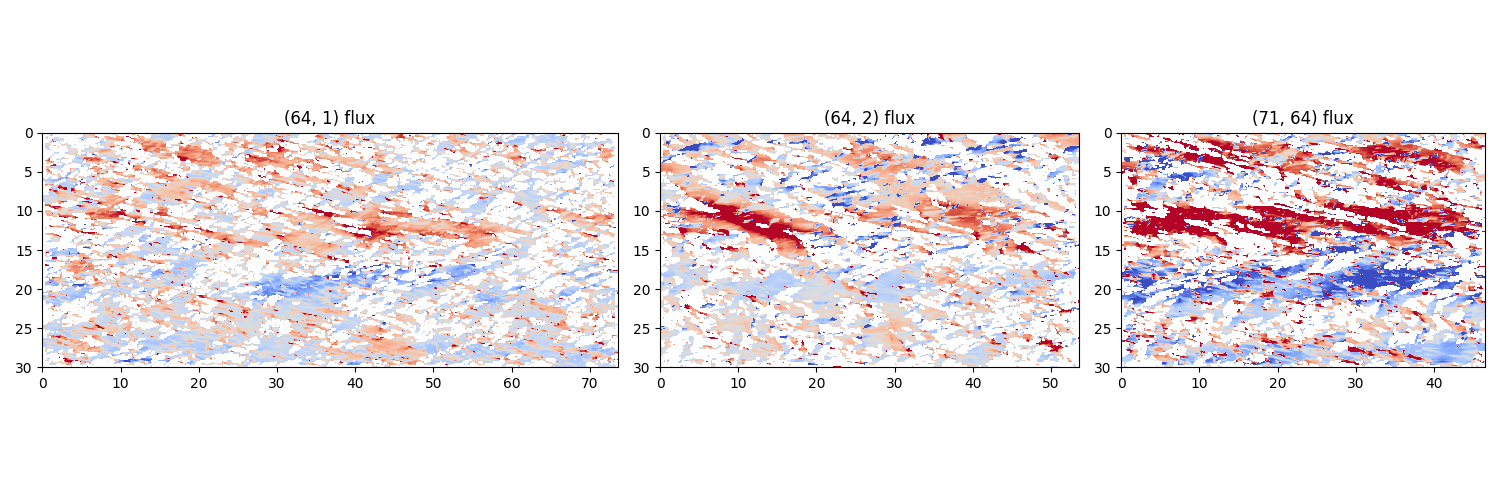

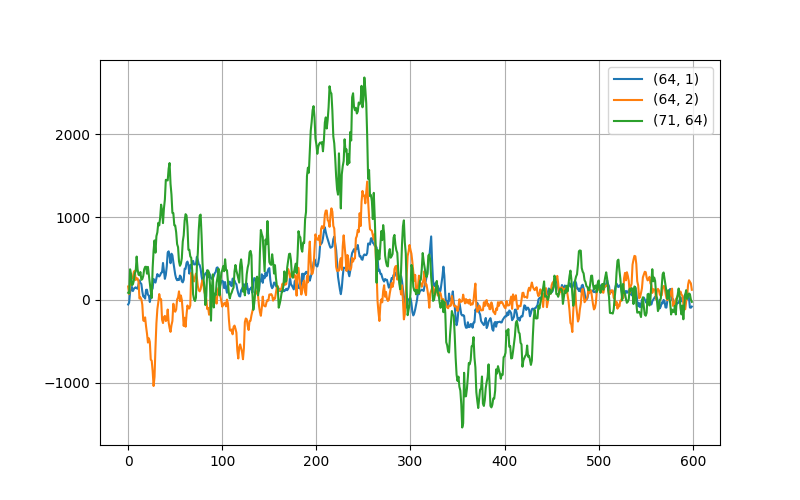

In [5]:
all_transport_plots = {}
width_ratios = []
speed_lefts = []
speed_rights = []
flux_tots = []
edge_names = []

for k, i in enumerate(edge_interests):
    edge_folder = edge_folders[i]
    img_max = 100
    edge_name = edge_folder.split('/')[-1][5:]
    edge_names.append(edge_name)
    speeds_address = glob.glob(edge_folder + '/*speeds*.tiff')[0]
    [speed_left, speed_right, flux_tot] = imageio.imread(speeds_address)
    speed_lefts.append(speed_left)
    speed_rights.append(speed_right)
    flux_tots.append(flux_tot)
    width_ratios.append(len(flux_tot[0]))
    
fig,ax = plt.subplots(1,3, figsize = (15,5), width_ratios=width_ratios)
    
for i in range(3):
    imshow_extent = [0, space_pixel_size * flux_tots[i].shape[1],
                 time_pixel_size * flux_tots[i].shape[0], 0]
    ax[i].imshow(flux_tots[i], vmin=-300, vmax=300, cmap='coolwarm', extent=imshow_extent)
    ax[i].set_title(f"{edge_names[i]} flux")
fig.tight_layout()    

fig, ax = plt.subplots(figsize=(8,5))
for i in range(3):
    ax.plot(np.nansum(flux_tots[i], axis=1) / (space_pixel_size * flux_tots[i].shape[1]), label=f"{edge_names[i]}")
ax.grid(True)
ax.legend()


# junction_sum = {}

# for key in junctions:
#     junction_sum[key] = np.zeros(np.array(tran_mean_total).shape)

# for key in all_transport_plots:
#     edge_array = [int(node) for node in key[1:-1].split(', ')]
#     if edge_array[0] in junctions:
# #         index = (np.where(junctions[edge_array[0]] == edge_array[1]))[0]
#         junction_sum[edge_array[0]] += all_transport_plots[key]
# #         print(junction_sum[edge_array[0]])
# #         print(index)
        
#     if edge_array[1] in junctions:        
#         junction_sum[edge_array[1]] -= all_transport_plots[key]

# #         index = (np.where(junctions[edge_array[1]] == edge_array[0]))[0]
# #         print(index)

# # print(junction_sum)
# for key in junction_sum:
# #     fig, ax = plt.subplots(figsize=(9,9))
#     for i in range(len(junction_sum[key])):
#         ax_trans.plot(junction_sum[key][i], c='blue')
#         ax_trans.set_title(f'Sum of junction node {key}')
        